In [0]:
 !nvidia-smi

In [0]:
################################ Data set: x_train from git #############################
###Data-set : v3457
import pandas as pd
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/x_train_v3457.csv?token=AE4WVKDPGVM56QVCI5J6INS5EUQV4'
x_train_v3457 = pd.read_csv(url, delimiter=';', skiprows=1, usecols=range(23), header=None)
#x_train1 = pd.read_csv(url, skiprows=1, header=None)
################################ Data set: y_train #############################
###Data-set : v3457
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/y_train_v3457.csv?token=AE4WVKFHICWRRBDPCAJL6MK5EUQYW'
y_train_v3457 = pd.read_csv(url, skiprows=1, header=None)

In [0]:
# Balance classes distribution
x_train2 = x_train_v3457.copy()
y_train2 = y_train_v3457.copy()
x_train2['Unroll'] = y_train2 
class0 = x_train2[x_train2['Unroll'] == 0]
class1 = x_train2[x_train2['Unroll'] == 1]
class2 = x_train2[x_train2['Unroll'] == 2]
class3 = x_train2[x_train2['Unroll'] == 3]
class4 = x_train2[x_train2['Unroll'] == 4]
class5 = x_train2[x_train2['Unroll'] == 5]
class6 = x_train2[x_train2['Unroll'] == 6]
### get the same number in each class 
class0 = class0[0:len(class2)]
class1 = class1[0:len(class2)]
class2 = class2[0:len(class2)]
class3 = class3[0:len(class2)]
class4 = class4[0:len(class2)]
class5 = class5[0:len(class2)]
class6 = class6[0:len(class2)]
# Build the new x_train
x_train = class0
x_train = x_train.append(class1)
x_train = x_train.append(class2)
x_train = x_train.append(class3)
x_train = x_train.append(class4)
x_train = x_train.append(class5)
x_train = x_train.append(class6)
len(x_train)
#Random inputs 
from sklearn.utils import shuffle
x_train = shuffle(x_train)
#Build new y_train 
y_train = x_train['Unroll']
#Drtop the added value from y_train
x_train.drop('Unroll', axis=1, inplace=True)
print("x_train len: ", len(x_train))

x_train len:  26670


In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import tensorboardcolab as tb
import numpy as np
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

class MLP():
  
    def __init__(self, x_data, y_data ,optmizer, kernel_initialization, kernel_regularizer,activation='relu'):
      
        self.batch_size = 100
        self.num_classes = 7
        self.epochs = 100000000
        #self.epochs = 150
        self.patience = 5
      
        self.x_data = x_data.copy()
        self.y_data = y_data.copy()
        
        self.optimizer = optmizer 
        self.kernel_initialization = kernel_initialization
        self.kernel_regularizer = kernel_regularizer
        self.activation = activation 

        
    def preprossing(self,x_train, y_train):
      # delete unimportant columns
      cols = [0,3,11,4]
      x_train.drop(x_train.columns[cols],axis=1,inplace=True)
      x_train.fillna(0, inplace=True)
    
      x_train = self.standarization(x_train)
      x_train, y_train, x_test, y_test = self.split_data(x_train, y_train)      
      y_train = np.array(y_train).flatten()
      y_test= np.array(y_test).flatten()
      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')
        # convert class vectors to binary class matrices
      y_train = keras.utils.to_categorical(y_train, self.num_classes)
      y_test = keras.utils.to_categorical(y_test, self.num_classes)
      
      return x_train, y_train, x_test, y_test

    def data_augmentation(self, df,fac):
      df.loc[:,6] *= fac
      df.loc[:,8] *= fac
      df.loc[:,10] *= fac
      df.loc[:,12] *= fac
      df.loc[:,16] *= fac
      return df 

    
    def standarization(self,x_train):
      from sklearn import preprocessing
      #Standarization: 
      x_scaler = preprocessing.StandardScaler().fit(x_train)
      x_train = x_scaler.transform(x_train)
      return x_train
  
    def split_data(self, x_train, y_train):
      import numpy as np
      #y_train = np.array(y_train).flatten()

      from sklearn.model_selection import train_test_split
      x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.2,train_size=0.8,random_state=9)
      return x_train, y_train , x_test, y_test 
   

    def multilayer_perceptron(self): 

      model = Sequential()
      model.add(Dense(units=500, input_dim=self.x_train.shape[1], activation=self.activation, kernel_initializer=self.kernel_initialization,
                      bias_initializer="zeros", kernel_regularizer= self.kernel_regularizer))
      model.add(BatchNormalization())
      model.add(Dropout(0.12))

      model.add(Dense(units=400, activation=self.activation , kernel_initializer= self.kernel_initialization, bias_initializer="zeros",
                      kernel_regularizer= self.kernel_regularizer))
      model.add(BatchNormalization())
      model.add(Dropout(0.1))

      model.add(Dense(units=250, activation=self.activation , kernel_initializer= self.kernel_initialization, bias_initializer="zeros", 
                      kernel_regularizer= self.kernel_regularizer))
      model.add(BatchNormalization())
      model.add(Dropout(0.07))

      model.add(Dense(units=100, activation=self.activation , kernel_initializer= self.kernel_initialization, bias_initializer="zeros", 
                     kernel_regularizer= self.kernel_regularizer))
      model.add(BatchNormalization())
      model.add(Dropout(0.04))

      model.add(Dense(units= self.num_classes , activation="softmax"))
      
      model.compile(loss='categorical_crossentropy',
              optimizer=  self.optimizer,
              metrics=['accuracy'])
      
      return model
    
    def train(self):
      self.x_train, self.y_train, self.x_test, self.y_test = self.preprossing(self.x_data,self.y_data)
      self.model = self.multilayer_perceptron()
      

      #Set callback functions to early stop training and save the best model so far
      early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=self.patience, verbose=0, mode='auto')
      
      self.history = self.model.fit(self.x_train,# Features
                          self.y_train, # Target vector
                          batch_size= self.batch_size, # Number of observations per batch
                          epochs=self.epochs, # Number of epochs
                          callbacks=[early_stopping], # Early stopping
                          verbose=1, # Print description after each epoch
                          validation_split=0.2, #used for validation set every each epoch
                          validation_data=(self.x_test, self.y_test) # Test data-set to evaluate the model in the end of training
                          ) 
     
      self.score = self.model.evaluate(self.x_test, self.y_test, verbose=0)
      print('Test loss:', self.score[0])
      print('Test accuracy:', self.score[1])
      
      from sklearn.metrics import classification_report
      import numpy as np

      Y_test = np.argmax(self.y_test, axis=1) # Convert one-hot to index
      y_pred = self.model.predict_classes(self.x_test)
      print(classification_report(Y_test, y_pred))
     
      ## Save the model 
      self.model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
      del self.model  # deletes the existing model
      
                                         
      #return self.history.history['loss'], self.history.history['val_loss']
      #return self.history.history['loss'],self.history.history['val_loss'], self.history.history['acc'], self.history.history['val_acc']      

Using TensorFlow backend.


In [0]:
#Lunch the training and save the model
if __name__=='__main__':   
  x_data = x_train.copy()
  y_data = y_train.copy()
  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_uniform'
  kernel_regularizer= None
  mlp_without = MLP(x_data, y_data,optimizer, kernel_initialization,kernel_regularizer)
  #loss, val_loss, acc, val_acc = mlp_without.train()
  mlp_without.train()

W0703 03:43:56.371192 140348943005568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 03:43:56.372872 140348943005568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 03:43:56.379019 140348943005568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 03:43:56.465621 140348943005568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0703 03:43:56.489507 

Train on 21336 samples, validate on 5334 samples
Epoch 1/100000000
21336/21336 [==============================] - 6s 300us/step - loss: 2.0633 - acc: 0.1543 - val_loss: 1.9734 - val_acc: 0.1734
Epoch 2/100000000
21336/21336 [==============================] - 2s 95us/step - loss: 1.9680 - acc: 0.1723 - val_loss: 1.9556 - val_acc: 0.1691
Epoch 3/100000000
21336/21336 [==============================] - 2s 94us/step - loss: 1.9526 - acc: 0.1841 - val_loss: 1.9455 - val_acc: 0.1839
Epoch 4/100000000
21336/21336 [==============================] - 2s 98us/step - loss: 1.9442 - acc: 0.1886 - val_loss: 1.9391 - val_acc: 0.1785
Epoch 5/100000000
21336/21336 [==============================] - 2s 96us/step - loss: 1.9364 - acc: 0.1926 - val_loss: 1.9395 - val_acc: 0.1916
Epoch 6/100000000
21336/21336 [==============================] - 2s 98us/step - loss: 1.9285 - acc: 0.1984 - val_loss: 1.9270 - val_acc: 0.1954
Epoch 7/100000000
21336/21336 [==============================] - 2s 97us/step - loss: 

In [0]:
################################ Test benchmarks : Data #############################
import pandas as pd
from google.colab import files
import io
uploaded1 = files.upload()
x_data= pd.read_csv(io.StringIO(uploaded1['benchmarks_data.csv'].decode('utf-8')),  delimiter=',', skiprows=1, usecols=range(23), header=None)

Saving benchmarks_data.csv to benchmarks_data.csv


In [0]:
################################ Test benchmarks : Real labels #############################
import pandas as pd
from google.colab import files
import io
uploaded1 = files.upload()
y_data = pd.read_csv(io.StringIO(uploaded1['becnhmarks_lables.csv'].decode('utf-8')), skiprows=1, header=None)

Saving becnhmarks_lables.csv to becnhmarks_lables.csv


In [0]:
# Predicted the factors of the entire benchmarks
cols = [0,3,11,4]
x_data.drop(x_data.columns[cols],axis=1,inplace=True)
x_data.fillna(0, inplace=True)
import numpy as np
y_data= np.array(y_data).flatten()
from keras.models import load_model
model = load_model('my_model.h5')
y_pred = model.predict_classes(x_data)
print(y_pred)

[5 5 5 0 0 0]


In [0]:
import sklearn
acc = sklearn.metrics.accuracy_score(np.array(y_pred), np.array(y_data))
print(acc)

0.0


In [0]:
print(y_data)

[1 4 0 3 1 2]


In [0]:
print(y_pred)

In [0]:
if __name__=='__main__':
  
     
  x_data = x_train_v3457.copy()
  y_data = y_train_v3457.copy()

  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_uniform'
  kernel_regularizer= None
  mlp_without = MLP(x_data, y_data,optimizer, kernel_initialization,kernel_regularizer)
  #loss, val_loss, acc, val_acc = mlp_without.train()
  mlp_without.train()

In [0]:
from sklearn.model_selection import train_test_split
x_train = x_train1.copy()
y_train = y_train1.copy()
cols = [0,3,11,4]
x_train.drop(x_train.columns[cols],axis=1,inplace=True)
x_train.fillna(0, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.02,train_size=0.8,random_state=9)
len(x_test)

1539

In [0]:
from keras.models import load_model

#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
y_pred = model.predict_classes(x_test)

import sklearn
acc = sklearn.metrics.accuracy_score(np.array(y_pred), 
                                     np.array(y_test))
print(acc)

In [0]:
import sklearn
acc = sklearn.metrics.accuracy_score(np.array(y_pred), 
                                     np.array(y_test))
print(acc)

0.1572449642625081


In [0]:
x_train1 = x_train.copy()
y_train1 = y_train.copy()
x_train1.fillna(0, inplace=True)
cols = [0,3,11,4]
x_train1.drop(x_train1.columns[cols],axis=1,inplace=True)
x_train1.fillna(0, inplace=True)
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train1,y_train1,test_size=0.2,train_size=0.8,random_state=9)
#Trying with decesion tree 
from sklearn.tree import DecisionTreeClassifier  
classifier = DecisionTreeClassifier()  
classifier.fit(x_train1, y_train1)
y_pred = classifier.predict(x_test1) 

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test1, y_pred))  
print(classification_report(y_test1, y_pred)) 

[[654 548 560 497]
 [625 586 590 404]
 [640 549 644 406]
 [460 445 402 888]]
              precision    recall  f1-score   support

           0       0.27      0.29      0.28      2259
           4       0.28      0.27      0.27      2205
           5       0.29      0.29      0.29      2239
           6       0.40      0.40      0.40      2195

    accuracy                           0.31      8898
   macro avg       0.31      0.31      0.31      8898
weighted avg       0.31      0.31      0.31      8898



In [0]:
################################ Data set: y_train #############################
import pandas as pd
from google.colab import files
import io
uploaded1 = files.upload()
y_train1 = pd.read_csv(io.StringIO(uploaded1['y_train.csv'].decode('utf-8')), skiprows=1, header=None)

Saving y_train.csv to y_train (1).csv


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98044df1d0>]],
      dtype=object)

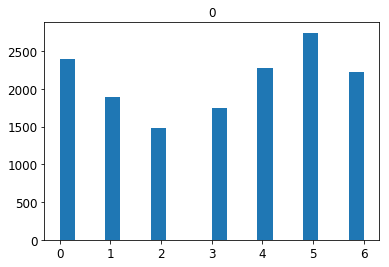

In [0]:
y_train1.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)

In [0]:
y_train1.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9812fd9208>]],
      dtype=object)

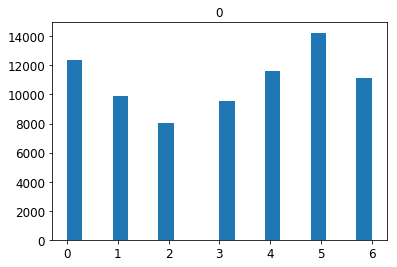

In [0]:
## Distribution de y
#from matplotlib import pyplot as plt
y_train1.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
#plt.title('Distribution des données dans les 64 classes', fontsize=16)
#plt.xlabel("Classes", fontsize=15)
#plt.ylabel("Nombre de données",fontsize=15)
#plt.xlim([-5,20])

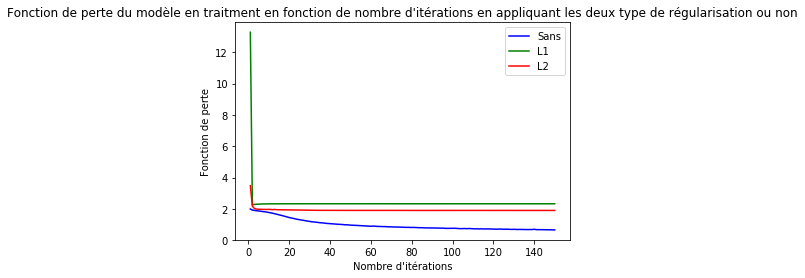

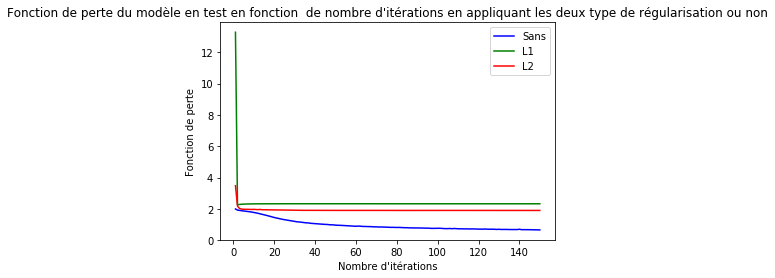

In [0]:
import matplotlib.pyplot as plt
import numpy as np 
  
  # Les plots 
  # Create count of the number of epochs
epoch_count = range(1, len(loss_adam1) + 1)



# y_train = np.array(y_train).flatten()
plt.plot(epoch_count, loss_without, 'b-')
plt.plot(epoch_count, loss_l1, 'g-')
plt.plot(epoch_count, loss_l2, 'r-')


   
  
plt.title("Fonction de perte du modèle en traitment en fonction de nombre d'itérations en appliquant les deux type de régularisation ou non")
plt.legend(['Sans' ,'L1', 'L2'])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte")
plt.show();
  
plt.plot(epoch_count, loss_without, 'b-')
plt.plot(epoch_count, loss_l1, 'g-')
plt.plot(epoch_count, loss_l2, 'r-')

  
  
plt.title("Fonction de perte du modèle en test en fonction  de nombre d'itérations en appliquant les deux type de régularisation ou non")
plt.legend(['Sans' ,'L1', 'L2'])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte")
plt.show();


In [0]:
################################ Data set: y_train #############################
import pandas as pd
from google.colab import files
import io
uploaded1 = files.upload()
y_train1 = pd.read_csv(io.StringIO(uploaded1['y_train.csv'].decode('utf-8')), skiprows=1, header=None)

In [0]:
################################ Data set: x_train #############################
import pandas as pd
from google.colab import files
import io
uploaded = files.upload()
x_train1 = pd.read_csv(io.StringIO(uploaded['x_train.csv'].decode('utf-8')), skiprows=1, usecols=range(23), header=None)

In [0]:
if __name__=='__main__':
  x_data = x_train1.copy()
  y_data = y_train1.copy()
  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_uniform'
  kernel_regularizer= None
  mlp_without = MLP(x_data, y_data,optimizer, kernel_initialization,kernel_regularizer)
  loss_without, val_loss_without = mlp_without.train()
  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_uniform'
  kernel_regularizer= keras.regularizers.l1()
  mlp_l1 = MLP(x_data, y_data,optimizer, kernel_initialization,kernel_regularizer)
  loss_l1, val_loss_l1 = mlp_l1.train()
  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_uniform'
  kernel_regularizer= keras.regularizers.l2()
  mlp_l2 = MLP(x_data, y_data,optimizer, kernel_initialization,kernel_regularizer)
  loss_l2, val_loss_l2 = mlp_l2.train()

  

In [0]:
import matplotlib.pyplot as plt
import numpy as np 
  
  # Les plots 
  # Create count of the number of epochs
epoch_count = range(1, len(loss_adam1) + 1)



# y_train = np.array(y_train).flatten()
plt.plot(epoch_count, loss_without, 'b-')
plt.plot(epoch_count, loss_l1, 'g-')
plt.plot(epoch_count, loss_l2, 'r-')


   
  
plt.title("Fonction de perte du modèle en traitment en fonction de nombre d'itérations en appliquant les deux type de régularisation ou non")
plt.legend(['Sans' ,'L1', 'L2'])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte")
plt.show();
  
plt.plot(epoch_count, loss_without, 'b-')
plt.plot(epoch_count, loss_l1, 'g-')
plt.plot(epoch_count, loss_l2, 'r-')

  
  
plt.title("Fonction de perte du modèle en test en fonction  de nombre d'itérations en appliquant les deux type de régularisation ou non")
plt.legend(['Sans' ,'L1', 'L2'])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte")
plt.show();


In [0]:
if __name__=='__main__':
  x_data = x_train1.copy()
  y_data = y_train1.copy()
  
  #pour tester diff diff initialization 
  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_normal'
  mlp_rn = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_rn, val_loss_rn = mlp_rn.train()
  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = 'random_uniform'
  mlp_ru = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_ru, val_loss_ru = mlp_ru.train()

  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = keras.initializers.VarianceScaling()
  mlp_vs = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_vs, val_loss_vs = mlp_vs.train()
   
    
  optimizer = keras.optimizers.Adam()
  kernel_initialization = keras.initializers.glorot_normal()
  mlp_gn = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_gn, val_loss_gn = mlp_gn.train()
  
      
  optimizer = keras.optimizers.Adam()
  kernel_initialization = keras.initializers.glorot_uniform()
  mlp_gu = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_gu, val_loss_gu = mlp_gu.train()
  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = keras.initializers.he_normal()
  mlp_he = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_he, val_loss_he = mlp_he.train()
  
  optimizer = keras.optimizers.Adam()
  kernel_initialization = keras.initializers.he_uniform()
  mlp_hu = MLP(x_data, y_data,optimizer, kernel_initialization)
  loss_hu, val_loss_hu = mlp_hu.train()

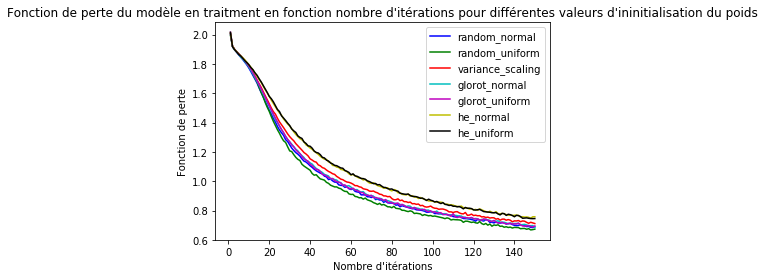

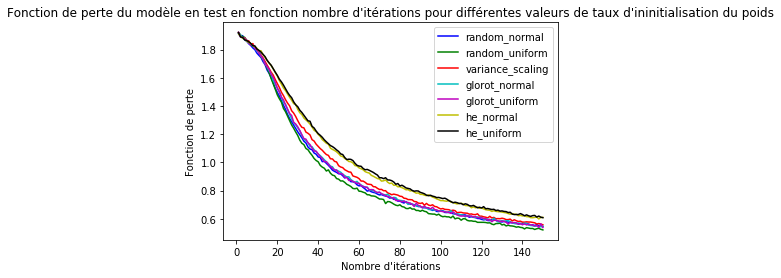

In [0]:
import matplotlib.pyplot as plt
import numpy as np 
  
  # Les plots 
  # Create count of the number of epochs
epoch_count = range(1, len(loss_rn) + 1)



# y_train = np.array(y_train).flatten()
plt.plot(epoch_count, loss_rn, 'b-')
plt.plot(epoch_count, loss_ru, 'g-')
plt.plot(epoch_count, loss_vs, 'r-')
plt.plot(epoch_count, loss_gn, 'c-')
plt.plot(epoch_count, loss_gu, 'm-')
plt.plot(epoch_count, loss_he, 'y-')
plt.plot(epoch_count, loss_hu, 'k-')

   
  
plt.title("Fonction de perte du modèle en traitment en fonction nombre d'itérations pour différentes valeurs d'ininitialisation du poids")
plt.legend(['random_normal' ,'random_uniform', 'variance_scaling', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte")
plt.show();
  
plt.plot(epoch_count, val_loss_rn, 'b-')
plt.plot(epoch_count, val_loss_ru, 'g-')
plt.plot(epoch_count, val_loss_vs, 'r-')
plt.plot(epoch_count, val_loss_gn, 'c-')
plt.plot(epoch_count, val_loss_gu, 'm-')
plt.plot(epoch_count, val_loss_he, 'y-')
plt.plot(epoch_count, val_loss_hu, 'k-')

  
  
plt.title("Fonction de perte du modèle en test en fonction nombre d'itérations pour différentes valeurs de taux d'ininitialisation du poids")
plt.legend(['random_normal' ,'random_uniform', 'variance_scaling', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte")
plt.show();


In [0]:
  # pour tester diff learning rate 
  
  optimizer = keras.optimizers.Adam()
  mlp_adam = MLP(x_data, y_data,optimizer)
  loss_adam, val_loss_adam = mlp_adam.train()
  
  optimizer = keras.optimizers.Adam(lr= 0.1)
  mlp_adam1 = MLP(x_data, y_data,optimizer)
  loss_adam1, val_loss_adam1 = mlp_adam1.train()
  
  optimizer = keras.optimizers.Adam(lr= 0.01)
  mlp_adam2 = MLP(x_data, y_data,optimizer)
  loss_adam2, val_loss_adam2 = mlp_adam2.train()
  
  optimizer = keras.optimizers.Adam(lr= 0.001)
  mlp_adam3 = MLP(x_data, y_data,optimizer)
  loss_adam3, val_loss_adam3 = mlp_adam3.train()
  
  optimizer = keras.optimizers.Adam(lr= 0.0001)
  mlp_adam4 = MLP(x_data, y_data,optimizer)
  loss_adam4, val_loss_adam4 = mlp_adam4.train()

In [0]:
import matplotlib.pyplot as plt
import numpy as np 
  
  # Les plots 
  # Create count of the number of epochs
epoch_count = range(1, len(loss_adam1) + 1)



# y_train = np.array(y_train).flatten()
plt.plot(epoch_count, loss_adam, 'k-')
plt.plot(epoch_count, loss_adam1, 'm-')
plt.plot(epoch_count, loss_adam2, 'y-')
plt.plot(epoch_count, loss_adam3, 'r-')
plt.plot(epoch_count, loss_adam4, 'c-')

  
  
 
  
  
plt.title("Fonction de perte du modèle en traitment en fonction nombre d'itérations pour différentes valeurs de taux d'apprentissage")
plt.legend(['Default value' ,'Rate 0.1', 'Rate 0.01', 'Rate 0.001', 'Rate 0.0001'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();
  
plt.plot(epoch_count, val_loss_adam, 'k-')
plt.plot(epoch_count, val_loss_adam1, 'm-')
plt.plot(epoch_count, val_loss_adam2, 'y-')
plt.plot(epoch_count, val_loss_adam3, 'r-')
plt.plot(epoch_count, val_loss_adam4, 'c-')

  
  
plt.title("Fonction de perte du modèle en test en fonction nombre d'itérations pour différentes valeurs de taux d'apprentissage")
plt.legend(['Default value' ,'Rate 0.1', 'Rate 0.01', 'Rate 0.001', 'Rate 0.0001'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

In [0]:
  #pour tester diff algo d'optimisation
  
  #mlp_sgd =   MLP(x_data, y_data,'sgd')
  #loss_sgd, val_loss_sgd, acc_sgd, val_acc_sgd = mlp_sgd.train()
  
  #mlp_adagard = MLP(x_data, y_data,'adagrad')
  #loss_adagard, val_loss_adagard, acc_adagard, val_acc_adagard = mlp_adagard.train()
  
  #mlp_adadelta = MLP(x_data, y_data,'adadelta')
  #loss_adadelta, val_loss_adadelta, acc_adadelta, val_acc_adadelta = mlp_adadelta.train()
    
  #mlp_adamax = MLP(x_data, y_data,'adamax')
  #loss_adamax, val_loss_adamax, acc_adamax, val_acc_adamax = mlp_adamax.train()
    
  #mlp_adam = MLP(x_data, y_data,'adam')
  #loss_adam, val_loss_adam, acc_adam, val_acc_adam = mlp_adam.train()
    
  #mlp_nadam = MLP(x_data, y_data,'nadam')
  #loss_nadam, val_loss_nadam, acc_nadam, val_acc_nadam = mlp_nadam.train()
    
  #mlp_rmsprop = MLP(x_data, y_data,'rmsprop')
  #loss_rmsprop, val_loss_rmsprop, acc_rmsprop, val_acc_rmsprop = mlp_rmsprop.train()  

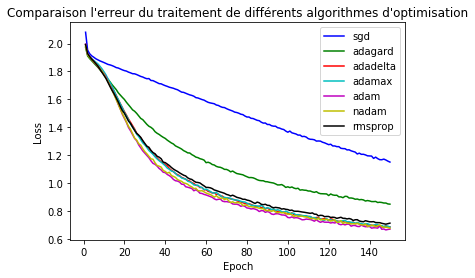

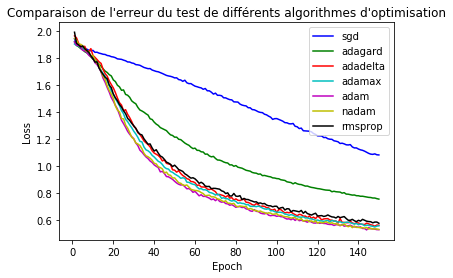

In [0]:
#plot de diff algo d'optimisation
import matplotlib.pyplot as plt
import numpy as np 
  
  # Les plots 
  # Create count of the number of epochs
epoch_count = range(1, len(loss_sgd) + 1)



# y_train = np.array(y_train).flatten()

plt.plot(epoch_count, loss_sgd, 'b-')
plt.plot(epoch_count, loss_adagard, 'g-')
plt.plot(epoch_count, loss_adadelta, 'r-')
plt.plot(epoch_count, loss_adamax, 'c-')
plt.plot(epoch_count, loss_adam, 'm-')
plt.plot(epoch_count, loss_nadam, 'y-')
plt.plot(epoch_count, loss_rmsprop, 'k-')
  
  
plt.title("Comparaison l'erreur du traitement de différents algorithmes d'optimisation")
plt.legend(['sgd', 'adagard', 'adadelta', 'adamax', 'adam', 'nadam', 'rmsprop'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();
  
  
  
plt.plot(epoch_count, val_loss_sgd, 'b-')
plt.plot(epoch_count, val_loss_adagard, 'g-')
plt.plot(epoch_count, val_loss_adadelta, 'r-')
plt.plot(epoch_count, val_loss_adamax, 'c-')
plt.plot(epoch_count, val_loss_adam, 'm-')
plt.plot(epoch_count, val_loss_nadam, 'y-')
plt.plot(epoch_count, val_loss_rmsprop, 'k-')
  
  
plt.title("Comparaison de l'erreur du test de différents algorithmes d'optimisation")
plt.legend(['sgd', 'adagard', 'adadelta', 'adamax', 'adam', 'nadam', 'rmsprop'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


In [0]:
plt.plot(epoch_count, acc_sgd, 'b-')
plt.plot(epoch_count, acc_adagard, 'g-')
plt.plot(epoch_count, acc_adadelta, 'r-')
plt.plot(epoch_count, acc_adamax, 'c-')
plt.plot(epoch_count, acc_adam, 'm-')
#plt.plot(epoch_count, acc_nadam, 'y-')
#plt.plot(epoch_count, acc_rmsprop, 'k-')
  
  
plt.title("Comparaison de la précision du traitement de différentes algorithmes d'optimisation")
#plt.legend(['sgd', 'adagard', 'adadelta', 'adamax', 'adam', 'nadam', 'rmsprop'])
plt.legend(['sgd', 'adagard', 'adadelta', 'adamax', 'adam', 'nadam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();
  
  
plt.plot(epoch_count, val_acc_sgd, 'b-')
plt.plot(epoch_count, val_acc_adagard, 'g-')
plt.plot(epoch_count, val_acc_adadelta, 'r-')
plt.plot(epoch_count, val_acc_adamax, 'c-')
plt.plot(epoch_count, val_acc_adam, 'm-')
#plt.plot(epoch_count, val_acc_nadam, 'y-')
#plt.plot(epoch_count, val_acc_rmsprop, 'k-')
  
  
plt.title("Comparaison de la précision du test de différentes algorithmes d'optimisation")
#plt.legend(['sgd', 'adagard', 'adadelta', 'adamax', 'adam', 'nadam', 'rmsprop'])
plt.legend(['sgd', 'adagard', 'adadelta', 'adamax', 'adam' , 'nadam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show(); 

In [0]:
loss_sgd = np.array(loss_sgd[0:176]).flatten()
loss_adagard = np.array(loss_adagard[0:176]).flatten()
loss_adadelta= np.array(loss_adadelta[0:176]).flatten()
loss_adamax = np.array(loss_adamax[0:176]).flatten()
loss_adam = np.array(loss_adam[0:176]).flatten()
loss_nadam = np.array(loss_nadam[0:176]).flatten()

val_loss_sgd = np.array(val_loss_sgd[0:176]).flatten()
val_loss_adagard = np.array(val_loss_adagard[0:176]).flatten()
val_loss_adadelta= np.array(val_loss_adadelta[0:176]).flatten()
val_loss_adamax = np.array(val_loss_adamax[0:176]).flatten()
val_loss_adam = np.array(val_loss_adam[0:176]).flatten()
val_loss_nadam = np.array(val_loss_nadam[0:176]).flatten()


acc_sgd = np.array(val_loss_sgd[0:176]).flatten()
acc_adagard = np.array(acc_adagard[0:176]).flatten()
acc_adadelta= np.array(acc_adadelta[0:176]).flatten()
acc_adamax = np.array(acc_adamax[0:176]).flatten()
acc_adam = np.array(acc_adam[0:176]).flatten()
acc_nadam = np.array(acc_nadam[0:176]).flatten()

val_acc_sgd = np.array(val_acc_sgd[0:176]).flatten()
val_acc_adagard = np.array(val_acc_adagard[0:176]).flatten()
val_acc_adadelta= np.array(val_acc_adadelta[0:176]).flatten()
val_acc_adamax = np.array(val_acc_adamax[0:176]).flatten()
val_acc_adam = np.array(val_acc_adam[0:176]).flatten()
val_acc_nadam = np.array(val_acc_nadam[0:176]).flatten()

# Other things

In [0]:
#Normalization 
from sklearn import preprocessing
x_normalizer = preprocessing.Normalizer().fit(x_train)  # fit does nothing
x_normalizer
x_train = x_normalizer.transform(x_train)

In [0]:
from matplotlib import pyplot as plt
y.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
#plt.title('Distribution des données dans les 64 classes', fontsize=16)
#plt.xlabel("Classes", fontsize=15)
#plt.ylabel("Nombre de données",fontsize=15)
#plt.xlim([-5,20])

In [0]:
def data_augmentation_2(df,new_span):
  prev_span = df.loc[:,16] 
  df.loc[:,6] *= new_span 
  df.loc[:,6] /= prev_span
  
  df.loc[:,8] *= new_span
  df.loc[:,8] /= prev_span
  df.loc[:,10] *= new_span 
  df.loc[:,10] /= prev_span
  df.loc[:,12] *= new_span 
  df.loc[:,12] /= prev_span 
  df.loc[:,16] *= new_span
  df.loc[:,16] /= prev_span 

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

In [0]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
# All data needs to be scaled to a small range like 0 to 1 for the neural network to work well. 
# Create scalers for the inputs 
X_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the training inputs 
x_treain = X_scaler.fit_transform(x_train)
print(x_train.shape)

# Feature Selctor

In [0]:
from feature_selector import FeatureSelector
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = x_train1, labels = y_train1)

In [0]:
x_train

In [0]:
fs.identify_missing(missing_threshold = 0.6)

2 features with greater than 0.60 missing values.



In [0]:
fs.missing_stats.head()

,missing_fraction
22,0.811669
15,0.671934
21,0.495571
20,0.365027
14,0.347449


In [0]:
missing_features = fs.ops['missing']
missing_features[:22]

[15, 22]

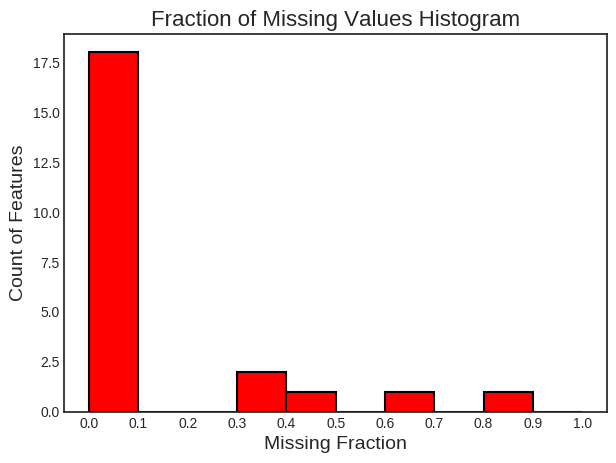

In [0]:
fs.plot_missing()

In [0]:
fs.missing_stats.head(10)

,missing_fraction
22,0.812695
15,0.673892
21,0.492684
20,0.368649
14,0.351646
19,0.044235
18,0.035835
12,0.000000
17,0.000000
16,0.000000


In [0]:
fs.identify_single_unique()

1 features with a single unique value.



In [0]:
single_unique = fs.ops['single_unique']
single_unique

[3]

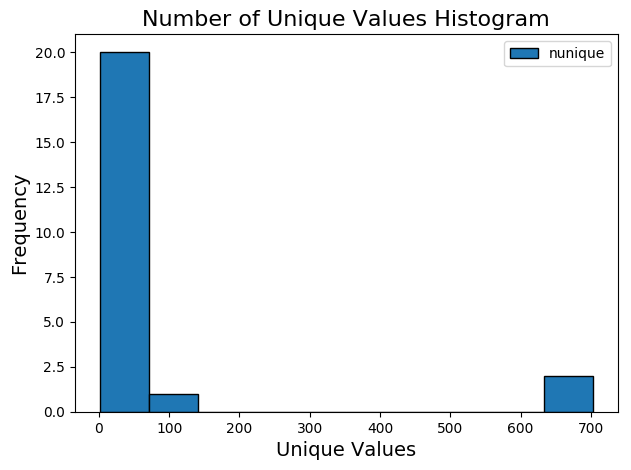

In [0]:
fs.plot_unique()

In [0]:
fs.unique_stats.sample(22)

,nunique
2,25
13,703
0,6
10,17
3,1
4,2
14,127
7,8
17,22
18,13



# 3. Collinear (highly correlated) Features

In [0]:
fs.identify_collinear(correlation_threshold=0.975)

1 features with a correlation magnitude greater than 0.97.



In [0]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

[11]

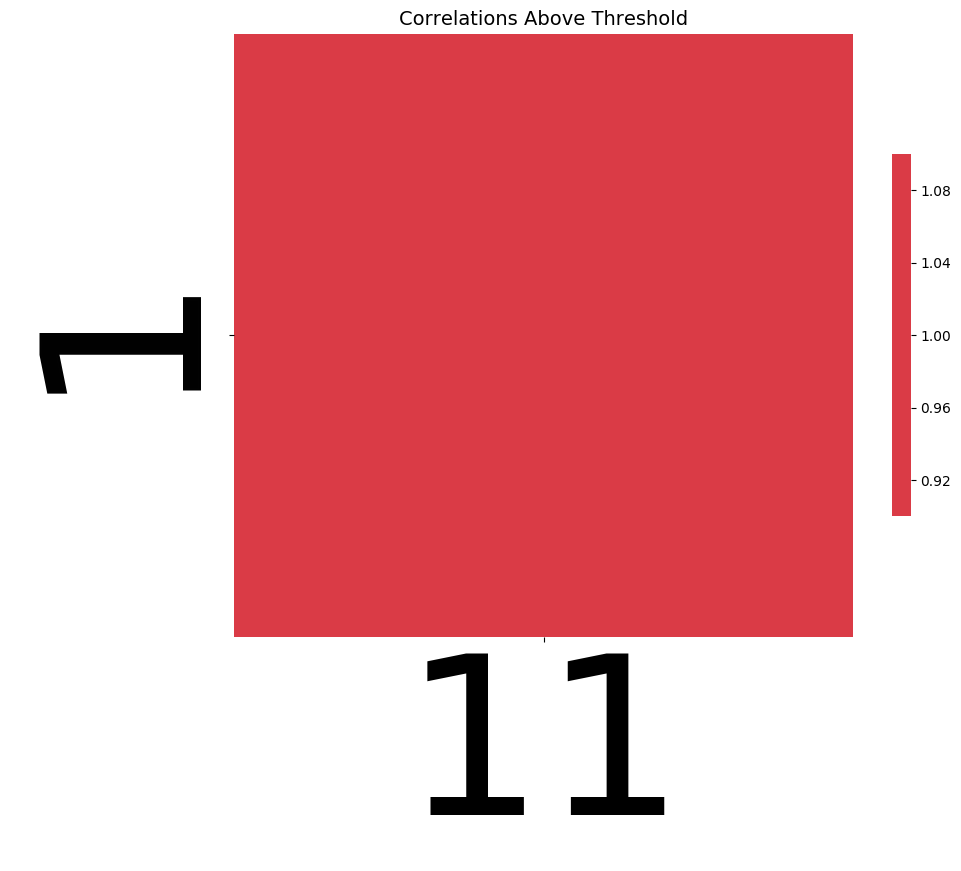

In [0]:
fs.plot_collinear()

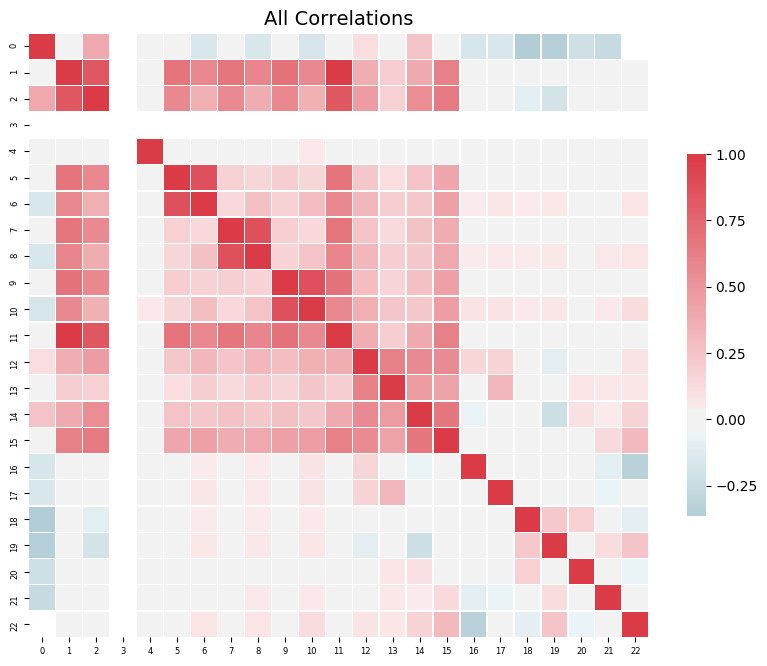

In [0]:
fs.plot_collinear(plot_all=True)

1 features with a correlation magnitude greater than 0.98.



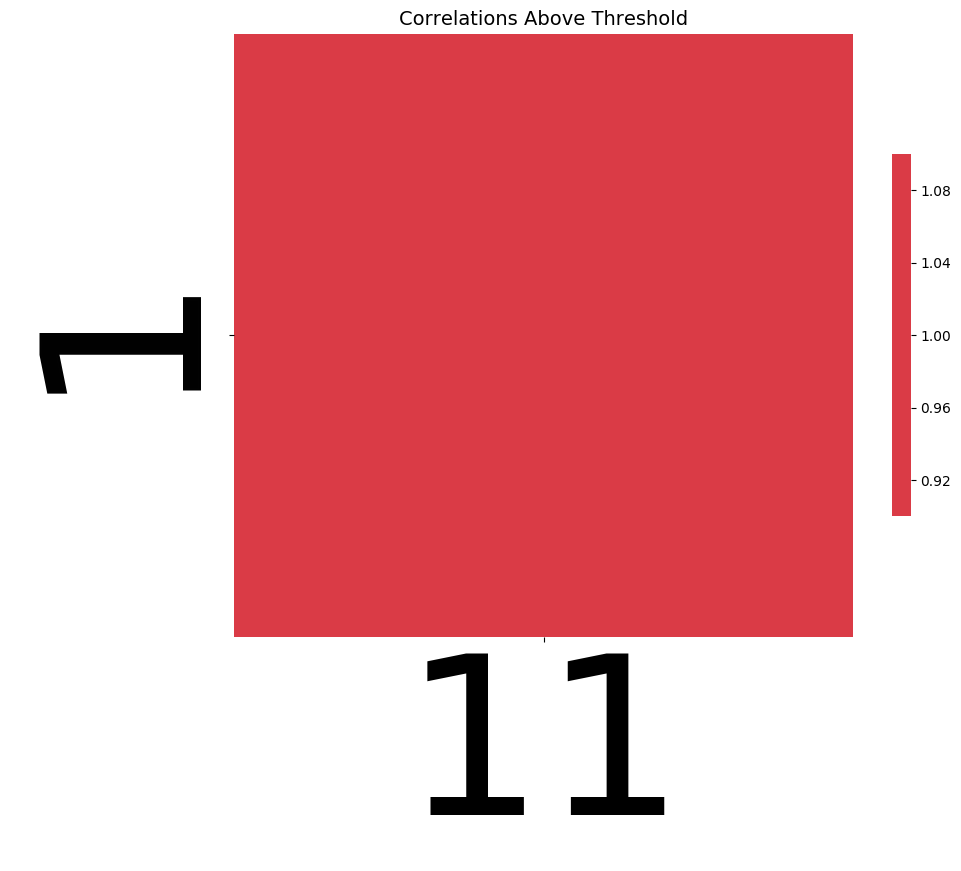

In [0]:
fs.identify_collinear(correlation_threshold=0.98)
fs.plot_collinear()

In [0]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,11,1,1.0


# 4. Zero Importance Features

In [0]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'multi_logloss', n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 1.8649	valid_0's multi_logloss: 1.8649
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 1.85763	valid_0's multi_logloss: 1.85763
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 1.86262	valid_0's multi_logloss: 1.86262
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 1.86643	valid_0's multi_logloss: 1.86643
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 1.86736	valid_0's multi_logloss: 1.86736
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[113]	valid_0's multi_

In [0]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 23 original features
There are 0 one-hot features


In [0]:
fs.data_all.head(10)

In [0]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[0:22]

[3, 11]

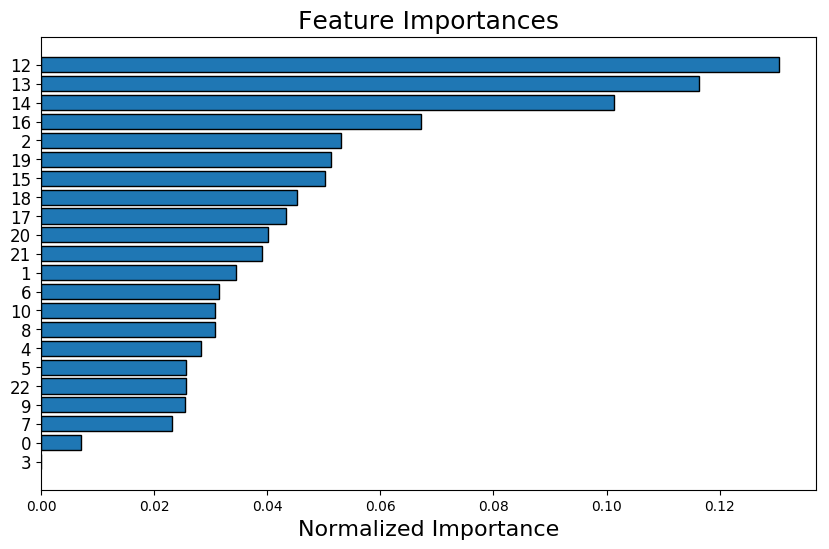

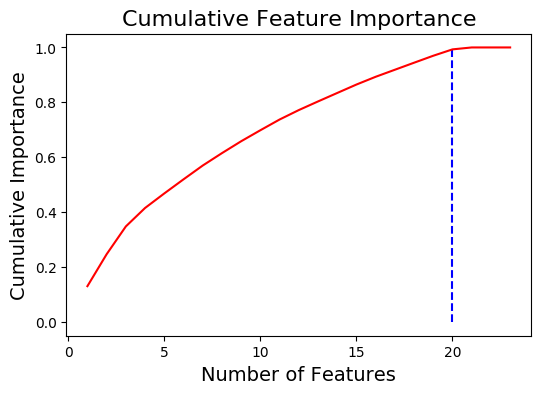

20 features required for 0.99 of cumulative importance


In [0]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 22)

In [0]:
fs.feature_importances.head(22)

,feature,importance,normalized_importance,cumulative_importance
0,12,2729.6,0.130503,0.130503
1,13,2433.5,0.116346,0.246849
2,14,2117.9,0.101257,0.348107
3,16,1404.7,0.067159,0.415266
4,2,1107.8,0.052964,0.468230
5,19,1073.4,0.051320,0.519550
6,15,1051.4,0.050268,0.569817
7,18,945.2,0.045190,0.615008
8,17,905.6,0.043297,0.658305
9,20,838.7,0.040098,0.698403


In [0]:
one_hundred_features = list(fs.feature_importances.loc[:22, 'feature'])
len(one_hundred_features)

23


# 5. Low Importance Features

In [0]:
fs.identify_low_importance(cumulative_importance = 0.99)

19 features required for cumulative importance of 0.99 after one hot encoding.
4 features do not contribute to cumulative importance of 0.99.



In [0]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

[4, 0, 3, 11]


# Removing Features

In [0]:
train_no_missing = fs.remove(methods = ['missing'])

Removed 2 features.


In [0]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])

Removed 4 features.


In [0]:
all_to_remove = fs.check_removal()
all_to_remove[0:22]

Total of 6 features identified for removal


[0, 3, 4, 11, 15, 22]

In [0]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,5,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,134144,128.0,NaN,4,16,128.0,64.0,64.0,NaN,NaN
1,6,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,1664,1536.0,NaN,16,2,8.0,64.0,32.0,64.0,NaN
2,6,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,529408,5120.0,NaN,2,16,32.0,32.0,32.0,32.0,NaN
3,5,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,1664,1536.0,NaN,16,2,64.0,32.0,512.0,NaN,NaN
4,5,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,1664,1536.0,NaN,8,1,128.0,64.0,512.0,NaN,NaN
5,6,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,134144,5120.0,NaN,8,1,16.0,64.0,64.0,64.0,NaN
6,5,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,134144,5120.0,NaN,8,1,64.0,64.0,1024.0,NaN,NaN
7,6,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,1664,1536.0,NaN,32,1,16.0,32.0,64.0,32.0,NaN
8,6,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,529408,5120.0,NaN,1,16,16.0,64.0,32.0,64.0,NaN
9,6,12,10,0,0,3,100663296,2,67108864,1,33554432,7,658432,529408,5120.0,NaN,2,16,16.0,32.0,32.0,64.0,NaN


In [0]:
################################ Data set: x_train from git #############################
###Data-set : v3
import pandas as pd
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/x_train_v3.csv?token=AE4WVKAVM6QBC7R5F2L56WK5BPLOU'
x_train_v3 = pd.read_csv(url, delimiter=',', skiprows=1, usecols=range(23), header=None)
#x_train1 = pd.read_csv(url, skiprows=1, header=None)
################################ Data set: y_train #############################
###Data-set : v3
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/y_train_v3.csv?token=AE4WVKB3GWTW4Z3P5TMQJA25BPMH6'
y_train_v3 = pd.read_csv(url, skiprows=1, header=None)

################################ Data set: x_train from git #############################
###Data-set : v34
import pandas as pd
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/x_train_v34.csv?token=AE4WVKBWZT7IAUMTLWCTI625BPMQ2'
x_train_v34 = pd.read_csv(url, delimiter=';', skiprows=1, usecols=range(23), header=None)
#x_train1 = pd.read_csv(url, skiprows=1, header=None)

################################ Data set: y_train #############################
###Data-set : v34
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/y_train_v34.csv?token=AE4WVKHDWVY5JQB22G6VZ3K5BPMUY'
y_train_v34 = pd.read_csv(url, skiprows=1, header=None)
################################ Data set: x_train from git #############################
###Data-set : v345
import pandas as pd
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/x_train_v345.csv?token=AE4WVKH4ZTRUCMMTJNG2Q6K5BPMWU'
x_train_v345 = pd.read_csv(url, delimiter=';', skiprows=1, usecols=range(23), header=None)
#x_train1 = pd.read_csv(url, skiprows=1, header=None)
################################ Data set: y_train #############################
###Data-set : v345
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/y_train_v345.csv?token=AE4WVKHNSOKT7UTB6CT7VBK5BPMYE'
y_train_v345 = pd.read_csv(url, skiprows=1, header=None)
################################ Data set: x_train from git #############################
###Data-set : v34579
import pandas as pd
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/x_train_v34579.csv?token=AE4WVKHGWOBZUEVRRBITXXK5BPNAA'
x_train_v34579 = pd.read_csv(url, delimiter=';', skiprows=1, usecols=range(23), header=None)
#x_train1 = pd.read_csv(url, skiprows=1, header=None)
################################ Data set: y_train #############################
###Data-set : v34579
url = 'https://raw.githubusercontent.com/DinaTaklit/Loop-Unrolling-Tiramisu-Vf/master/y_train_v34579.csv?token=AE4WVKGYNUIBEQOZQG2244S5BPNCO'
y_train_v34579 = pd.read_csv(url, skiprows=1, header=None)

print('x_v3',len(x_train_v3))
print('y_v3',len(y_train_v3))

print('x_v34',len(x_train_v34))
print('y_v34',len(y_train_v34))

print('x_v345',len(x_train_v345))
print('y_v345',len(y_train_v345))

print('x_v3457',len(x_train_v3457))
print('y_v3457',len(y_train_v3457))

print('x_v34579',len(x_train_v34579))
print('y_v34579',len(y_train_v34579))

y_train_v3457.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)

x_train2 = x_train_v3457.copy()
y_train2 = y_train_v3457.copy()

x_train2['Unroll'] = y_train2 
class0 = x_train2[x_train2['Unroll'] == 0]
class1 = x_train2[x_train2['Unroll'] == 1]
class2 = x_train2[x_train2['Unroll'] == 2]
class3 = x_train2[x_train2['Unroll'] == 3]
class4 = x_train2[x_train2['Unroll'] == 4]
class5 = x_train2[x_train2['Unroll'] == 5]
class6 = x_train2[x_train2['Unroll'] == 6]
print("0: ",len(class0))
print("1: ",len(class1))
print("2: ",len(class2))
print("3: ",len(class3))
print("4: ",len(class4))
print("5: ",len(class5))
print("6: ",len(class6))

from sklearn.model_selection import train_test_split
x_train = x_train.copy()
y_train = y_train.copy()
cols = [0,3,11,4]
x_train.drop(x_train.columns[cols],axis=1,inplace=True)
x_train.fillna(0, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.02,train_size=0.8,random_state=9)
len(x_test)